A quick and easy tutorial on bootstrapping (and other related methods) for resampling and calculating uncertainties from correlated timeseries data.

References:

1. Grossfield A, Patrone PN, Roe DR, Schultz AJ, Siderius DW, Zuckerman DM. Best practices for quantification of uncertainty and sampling quality in molecular simulations. Living journal of computational molecular science. 2018;1(1). [DOI](https://doi.org/10.33011/livecoms.1.1.5067)

2. Shirts MR and Chodera JD. Statistically optimal analysis of samples from multiple equilibrium states. J. Chem. Phys. 129:124105 (2008). [DOI](http://dx.doi.org/10.1063/1.2978177)

3. Chodera JD, Swope WC, Pitera JW, Seok C, and Dill KA. Use of the weighted histogram analysis method for the analysis of simulated and parallel tempering simulations. J. Chem. Theor. Comput. 3(1):26-41 (2007). [DOI](http://dx.doi.org/10.1021/ct0502864)

4. Eichler M, Introduction to the boostrap (handout) [Link](http://galton.uchicago.edu/~eichler/stat24600/Handouts/bootstrap.pdf)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm
from pymbar.testsystems import correlated_timeseries_example
from statsmodels.tsa import stattools
import pymbar.timeseries

# Sampling basics

## Random sampling and the sampling distribution

Let's draw samples from a non-trivial distribution: a skewed normal distribution. This is the **population distribution**. The mean of this distribution is the **population mean** $\mu$, and the standard deviation is the **population standard deviation** $\sigma$

**Why a skewed distribution?**

To drive home the message that in the limit of large sample size, the sampling distribution (which we'll come to later) is normal, no matter what the population distribution looks like.

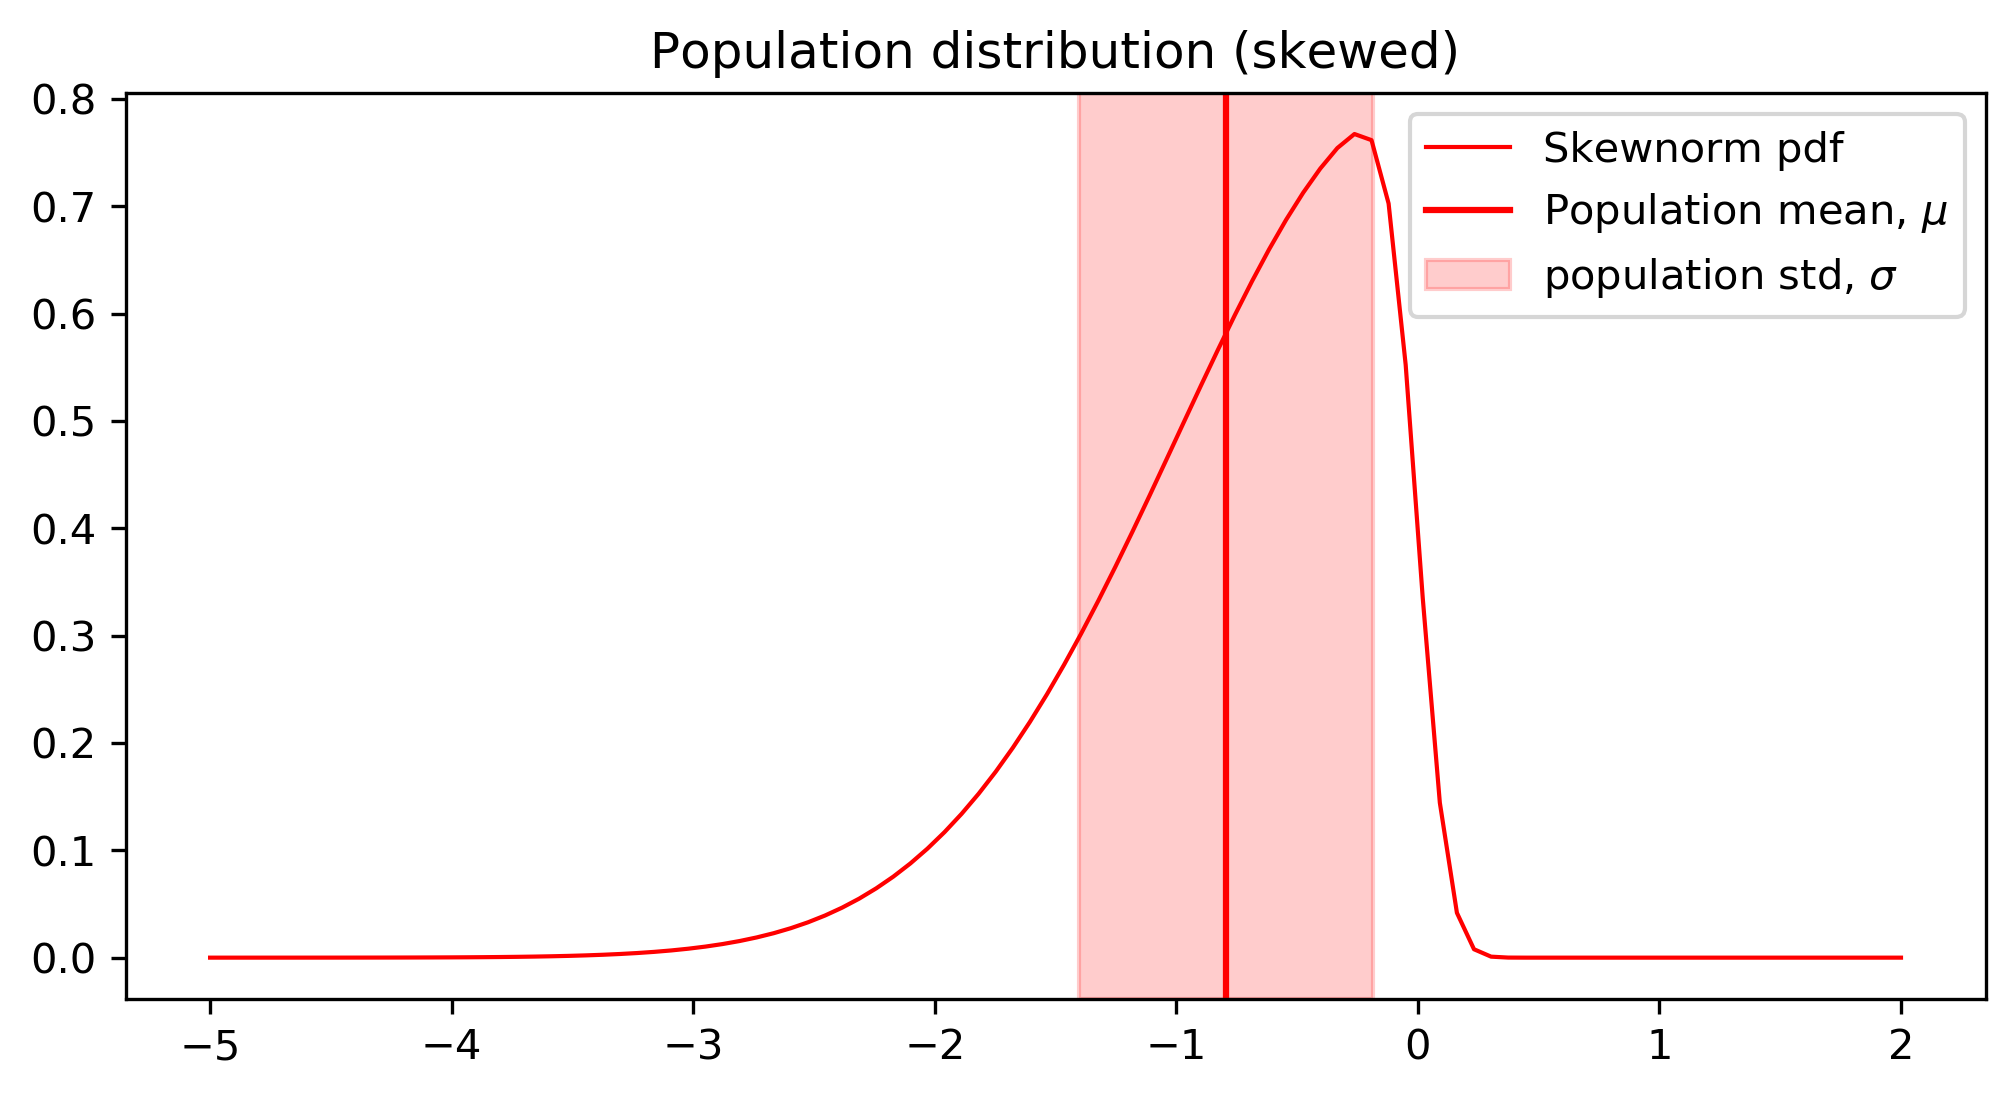

In [2]:
a = -10
# Population parameters
mean, var, skew = skewnorm.stats(a, moments='mvs')

# Plot population distribution
fig, ax = plt.subplots(figsize=(8,4), dpi=300)
x = np.linspace(-5, 2, 100)
ax.plot(x, skewnorm.pdf(x, a), 'r-', lw=1, label='Skewnorm pdf')
ax.axvline(mean, color='r', label=r'Population mean, $\mu$')
ax.axvspan(mean - np.sqrt(var), mean + np.sqrt(var), color='r', alpha=0.2, label=r'population std, $\sigma$')
ax.set_title("Population distribution (skewed)")
ax.legend()

Now, let's draw some random samples of different sizes from the population.

The empirical distributions of these samples should look similar to the population distribution. This should become more apparent as we increase the sample size. The code/figures below show that this is indeed the case.

The empirical mean of the sample is the **sample mean** $\bar{X}$, and the empirical standard deviation of the sample is the **sample standard deviation** $\sigma_s$

Text(0.5, 0.98, 'Random samples drawn from the distribution')

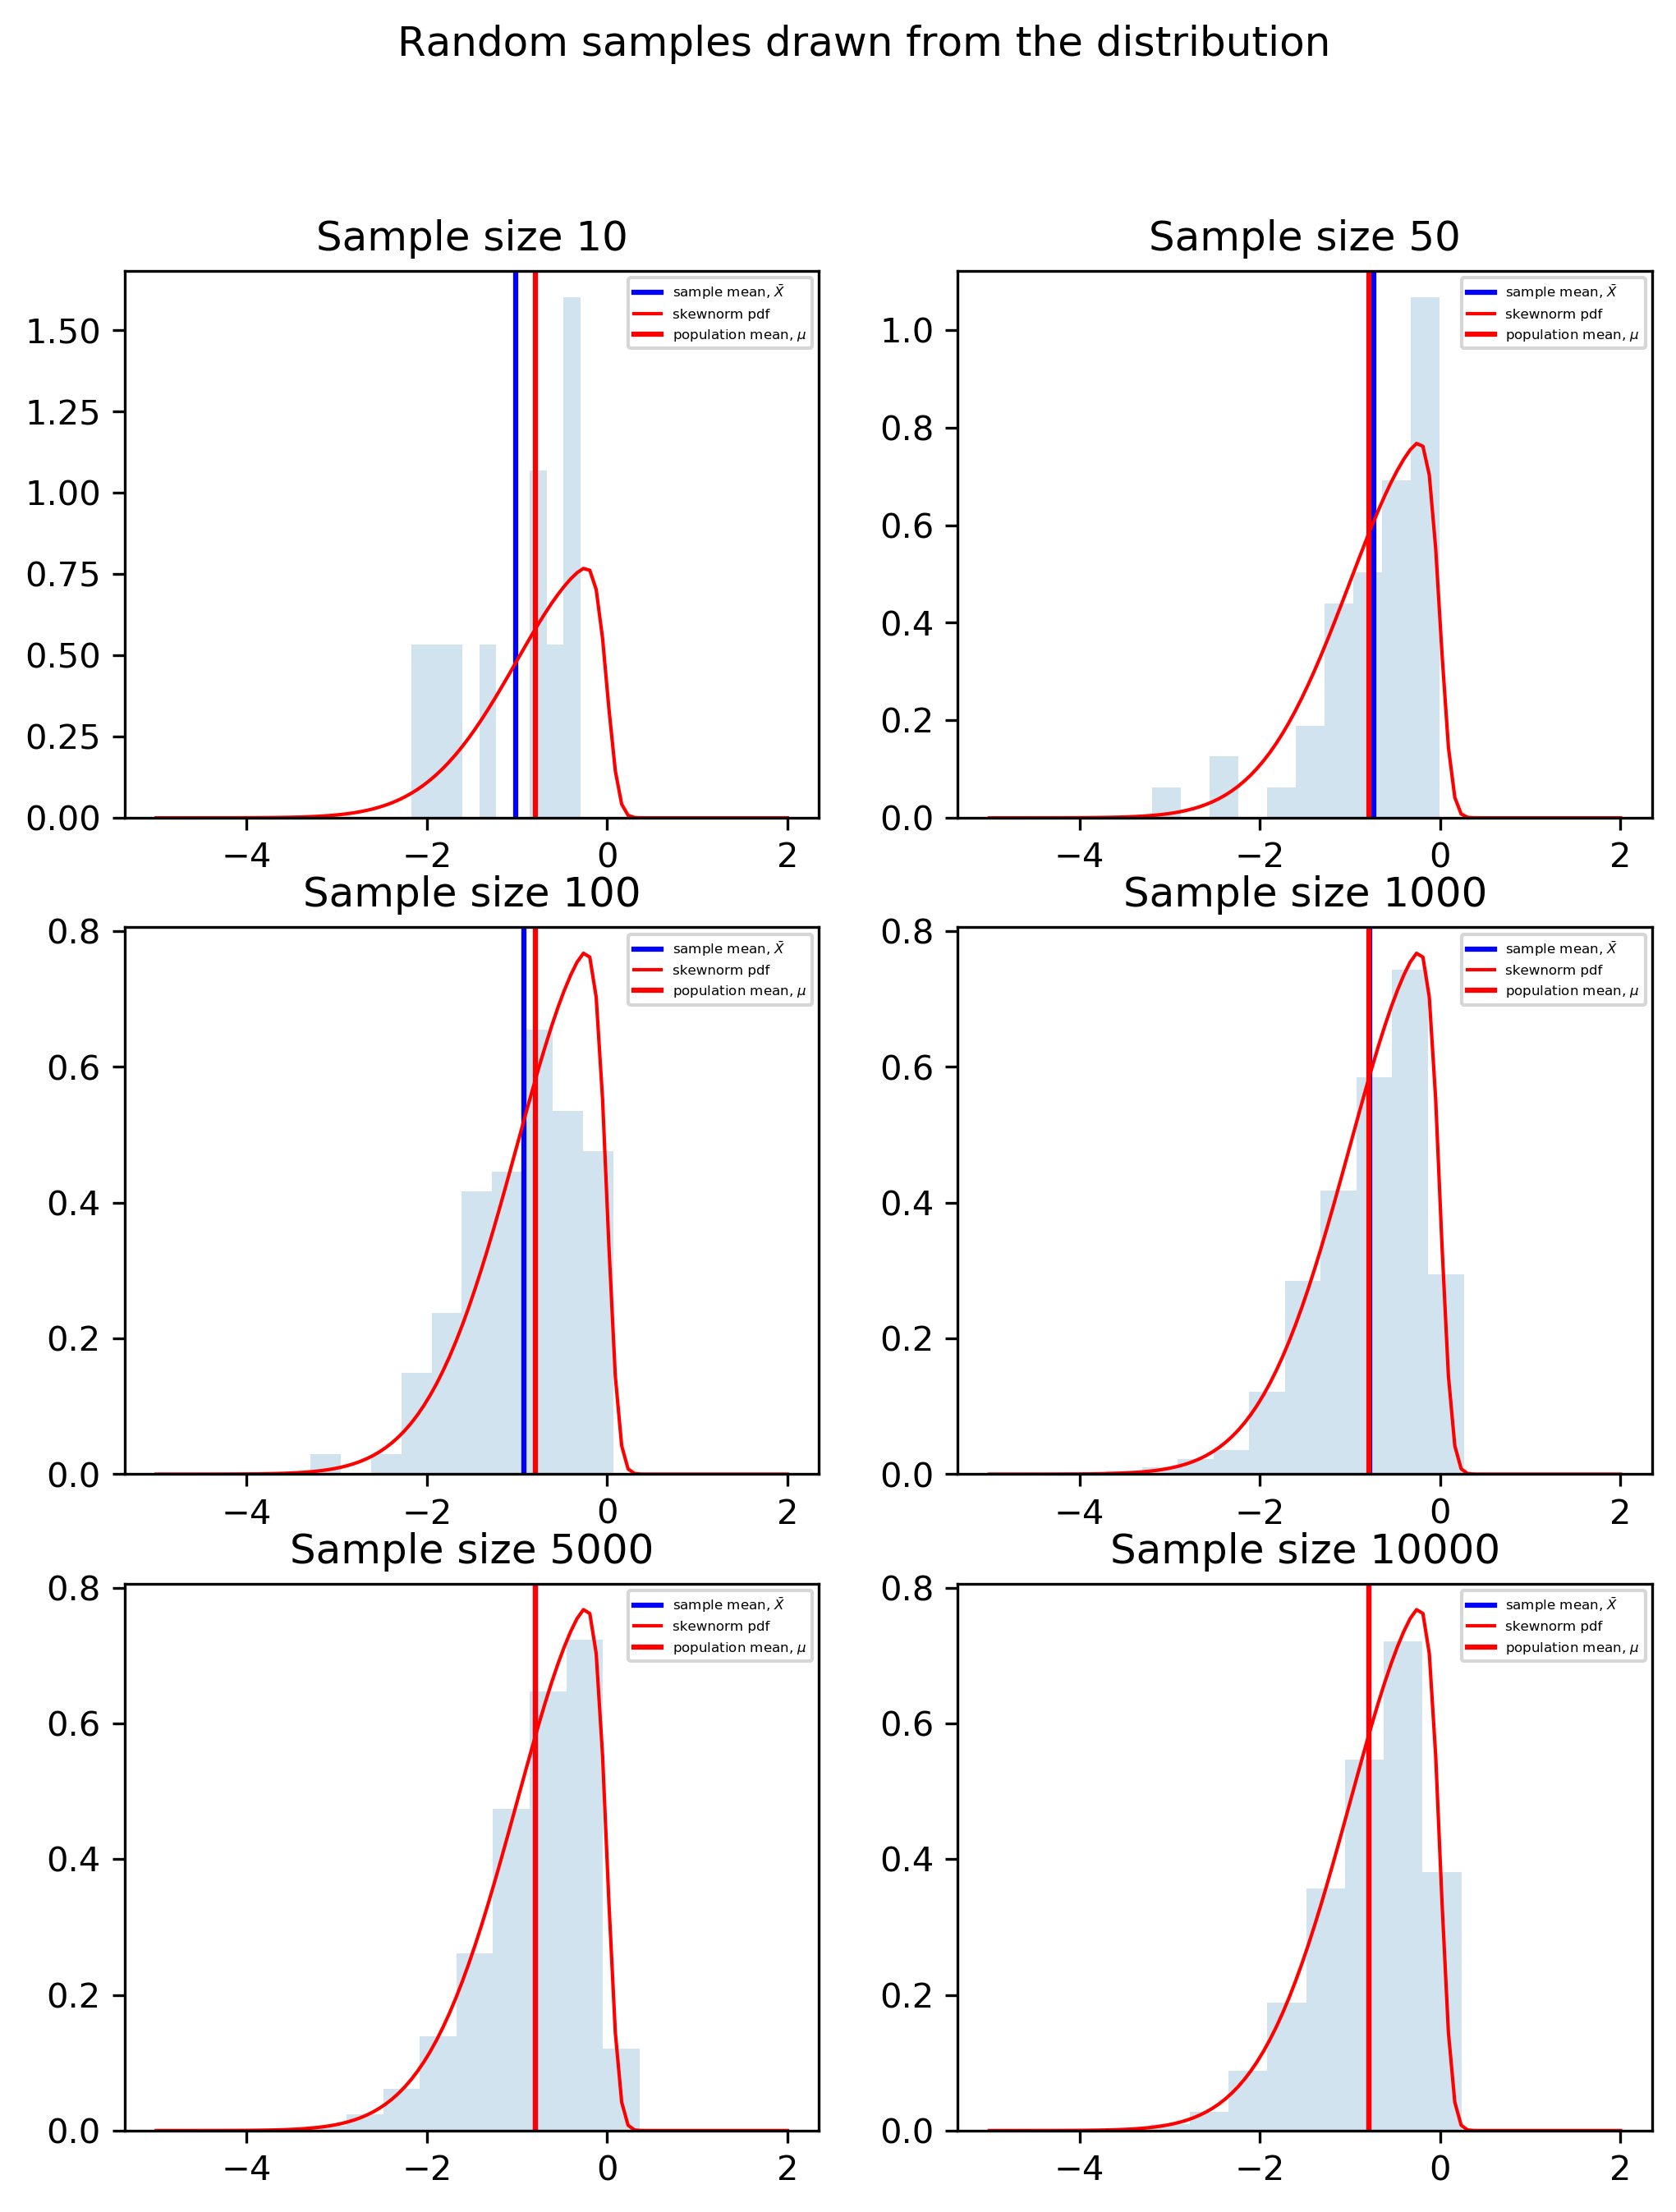

In [3]:
sample_sizes = [10, 50, 100, 1000, 5000, 10000]
fig, ax = plt.subplots(3, 2, figsize=(8,10), dpi=300)
for sidx, sample_size in enumerate(sample_sizes):
    sample = skewnorm.rvs(a, size=sample_size)
    rax = ax.reshape(-1)
    rax[sidx].hist(sample, density=True, histtype='stepfilled', alpha=0.2)
    rax[sidx].axvline(sample.mean(), color='b', label=r'sample mean, $\bar{X}$')
    
    rax[sidx].plot(x, skewnorm.pdf(x, a), 'r-', lw=1, label='skewnorm pdf')
    rax[sidx].axvline(mean, color='r', label=r'population mean, $\mu$')
    
    rax[sidx].legend(prop={'size': 4})
    rax[sidx].set_title('Sample size {}'.format(sample_size))
    
fig.suptitle("Random samples drawn from the distribution")

Let's fix a sample size $N$. Let's draw thousands of random samples of size $N$ from the population, and calculate the mean of each sample. What will the distribution of the means look like?

If number of samples drawn is large enough, it will be normally distributed, centered at the population mean $\mu$, and with a standard deviation $\sigma_{\bar{X}} = \sigma / \sqrt{N}$.

This distribution is the **sampling distribution of the mean**, and its standard deviation is the **standard error of the mean**.

Intuitively, with increasing $N$, the distributions get narrower/sharper. This means that the mean of a sample with larger sample size is likely to be much closer to the (true) population mean than the mean of a sample with smaller sample size.

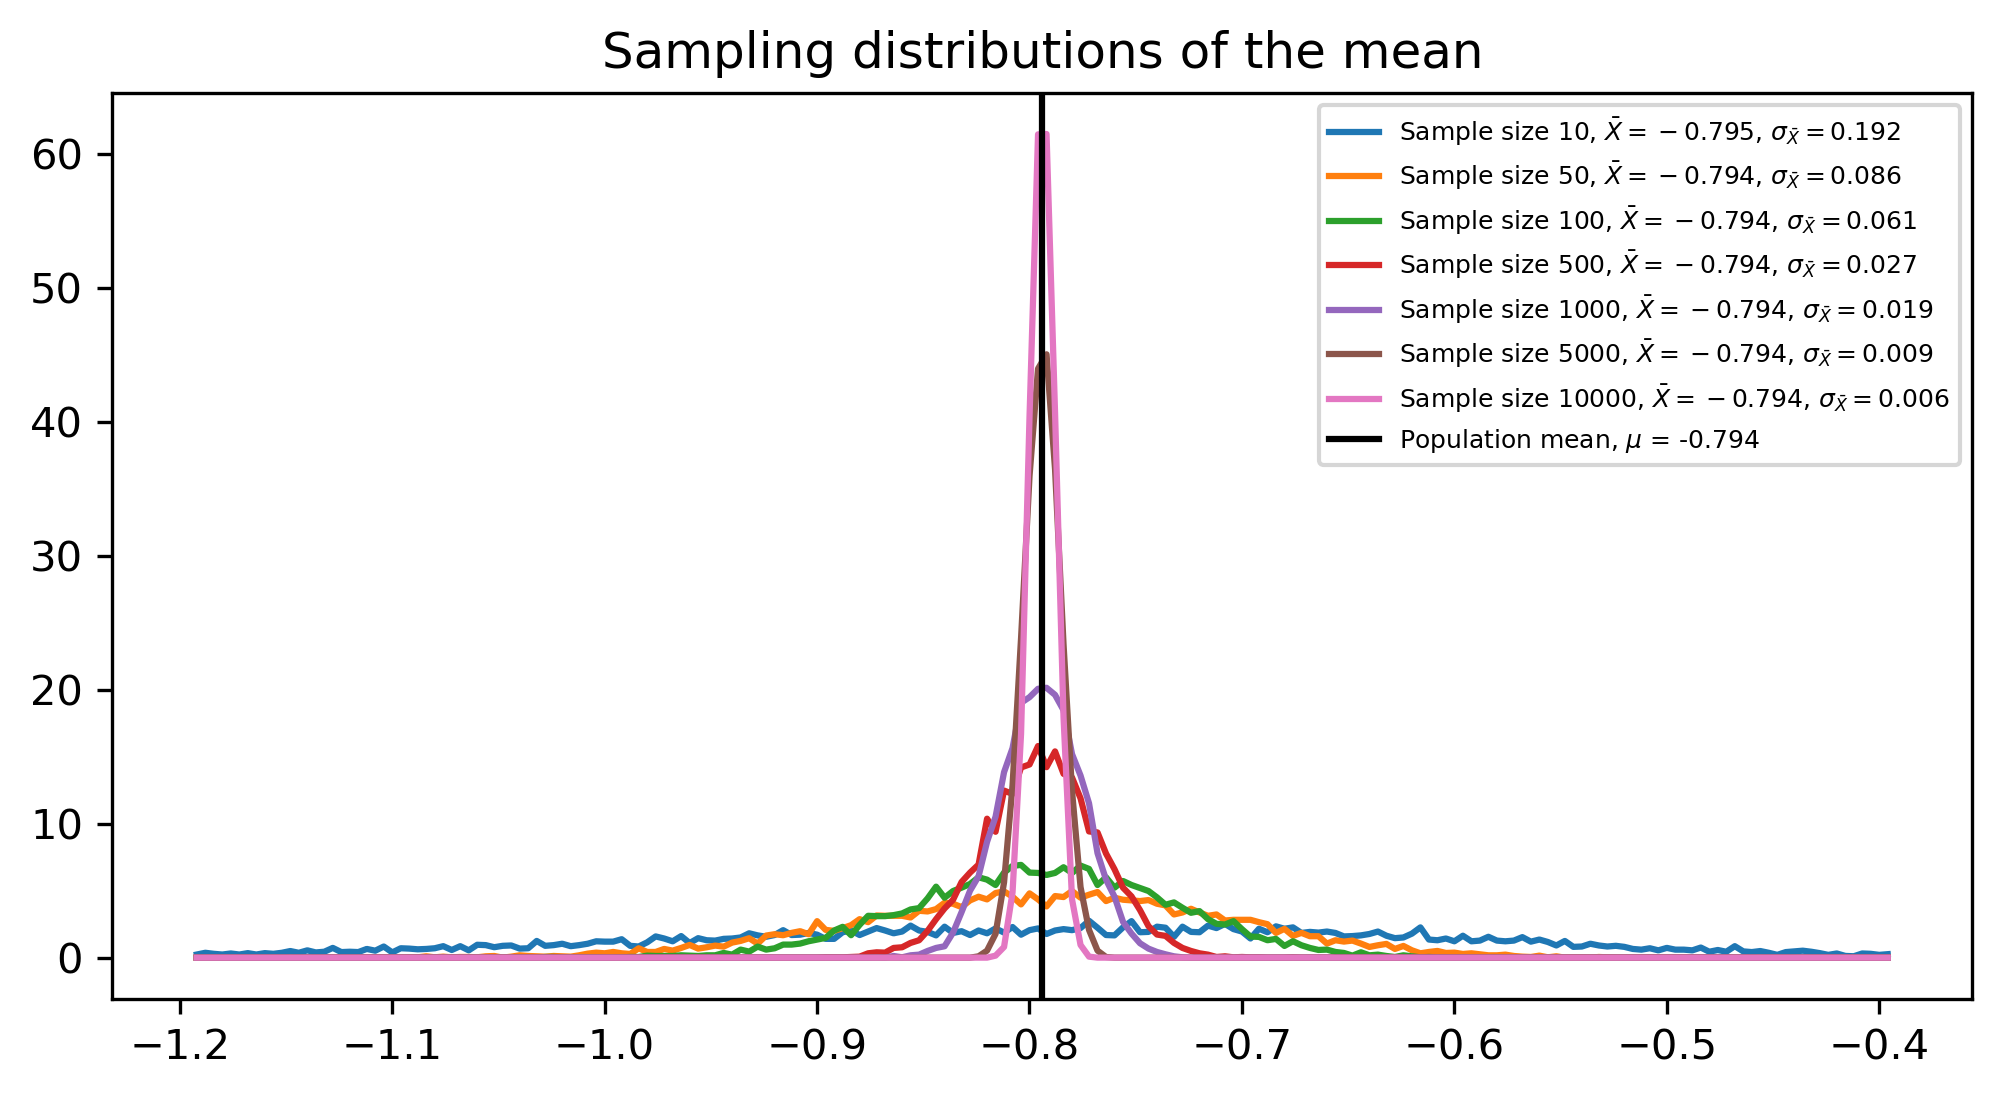

In [4]:
sample_sizes = [10, 50, 100, 500, 1000, 5000, 10000]

sampling_sigma_xbar = []

fig, ax = plt.subplots(figsize=(8,4), dpi=300)

for sidx, sample_size in enumerate(sample_sizes):
    sample_means = []
    for i in range(10000):
        sample = skewnorm.rvs(a, size=sample_size)
        sample_means.append(sample.mean())
    sample_means = np.array(sample_means)
    hist, edges = np.histogram(sample_means, bins=200, range= [mean - 0.4, mean + 0.4], density=True)
    histx = (edges[:-1] + edges[1:])/2
    ax.plot(histx, hist, label=r"Sample size %d, $\bar{X} = %.3f$, $\sigma_{\bar{X}} = %.3f$" % (sample_size, sample_means.mean(), sample_means.std()))
    sampling_sigma_xbar.append(sample_means.std())
    
ax.axvline(mean, color='black', label="Population mean, $\mu$ = {:.3f}".format(mean))
ax.set_title("Sampling distributions of the mean")
ax.legend(prop={'size': 6})

In [5]:
true_sigma_xbar = []
for sample_size in sample_sizes:
    population_sigma = np.sqrt(var)
    true_sigma_xbar.append(population_sigma / np.sqrt(sample_size))
    
print("sample size N \t\t\t", sample_sizes)
print("sigma_population/sqrt(N), \t", ["%.4f" % sx for sx in true_sigma_xbar])
print("std of sampling distributions:\t", ["%.4f" % sx for sx in sampling_sigma_xbar])

sample size N 			 [10, 50, 100, 500, 1000, 5000, 10000]
sigma_population/sqrt(N), 	 ['0.1923', '0.0860', '0.0608', '0.0272', '0.0192', '0.0086', '0.0061']
std of sampling distributions:	 ['0.1925', '0.0861', '0.0605', '0.0271', '0.0193', '0.0086', '0.0060']


## $\bar{x}$ (sample mean) and $\sigma_{\bar{x}}$ (standard error of mean) from a single sample 

We don't need to perform repeated sampling to find the standard error of the mean. The standard error of the mean $\sigma_{\bar{X}}$ can be estimated from *a single sample*, as

$\hat{\sigma}_{\bar{X}} = \sigma_s / \sqrt{N}$.

In [6]:
sample_sizes = [10, 50, 100, 500, 1000, 5000, 10000]
sample_mean = []
sample_sem = []

for sidx, sample_size in enumerate(sample_sizes):
    sample = skewnorm.rvs(a, size=sample_size)
    sample_mean.append(sample.mean())
    sample_sem.append(sample.std()/np.sqrt(sample_size))
    
print("sample size N \t", sample_sizes)
print("sample mean \t", ["%.4f" % x for x in sample_mean])
print("sample sem\t", ["%.4f" % x for x in sample_sem])

for sidx, sample_size in enumerate(sample_sizes):
    print(u"Sample size {:5}: True mean = {:.3f}, estimate from sample = {:.3f} \u00B1 {:.3f} (95 % CI)".format(sample_size, mean, sample_mean[sidx], 1.96 * sample_sem[sidx]))

sample size N 	 [10, 50, 100, 500, 1000, 5000, 10000]
sample mean 	 ['-0.7917', '-0.6434', '-0.8258', '-0.7563', '-0.8129', '-0.8070', '-0.7957']
sample sem	 ['0.2051', '0.0680', '0.0553', '0.0255', '0.0195', '0.0086', '0.0061']
Sample size    10: True mean = -0.794, estimate from sample = -0.792 ± 0.402 (95 % CI)
Sample size    50: True mean = -0.794, estimate from sample = -0.643 ± 0.133 (95 % CI)
Sample size   100: True mean = -0.794, estimate from sample = -0.826 ± 0.108 (95 % CI)
Sample size   500: True mean = -0.794, estimate from sample = -0.756 ± 0.050 (95 % CI)
Sample size  1000: True mean = -0.794, estimate from sample = -0.813 ± 0.038 (95 % CI)
Sample size  5000: True mean = -0.794, estimate from sample = -0.807 ± 0.017 (95 % CI)
Sample size 10000: True mean = -0.794, estimate from sample = -0.796 ± 0.012 (95 % CI)


## What if the sample points aren't independent?

Adding copies of the original (iid) data to the dataset increases the number of samples, which reduces $\sigma_{\bar{x}}$ while the sample mean $\bar{x}$ remains the same. 

Soon, the true population mean falls outside the 95 % CI constructed from the (artificial) sample!

**Why am I showing you this?**

This is very similar to what happens when data is autocorrelated. 

When estimating statistics from data with autocorrelation (such as timeseries observations from MCMC or MD simulations), the number of independent data points is far lower than the number of data points in the (timeseries) sample.

This can result in artificially low estimates of standard errors, if calculated naively.

**How do we deal with this issue?**

Bootstrapping!

(And some more techniques for timeseries, which I'll discuss in the next section).

In [7]:
replications = [1, 2, 5]
total_sample_sizes = []
sample_mean = []
sample_sem = []

for replication in replications:
    np.random.seed(seed=516123)
    orig_sample = skewnorm.rvs(a, size=50)
    
    sample = orig_sample
    # Add duplicate data
    for i in range(replication - 1):
        sample = np.append(sample, orig_sample)
        
    sample_mean.append(sample.mean())
    sample_sem.append(sample.std()/np.sqrt(len(sample)))
    total_sample_sizes.append(len(sample))
    
print("indepedent samples = 50")
print("total samples, N\t", total_sample_sizes)
print("sample mean\t\t", ["%.4f" % x for x in sample_mean])
print("sample sem\t\t", ["%.4f" % x for x in sample_sem])

for i in range(len(replications)):
    print(u"Ind. sample size = 50, total sample size {:5}: True mean = {:.3f}, estimate from sample = {:.3f} \u00B1 {:.3f} (95 % CI)".format(total_sample_sizes[i], mean, sample_mean[i], 1.96 * sample_sem[i]))

indepedent samples = 50
total samples, N	 [50, 100, 250]
sample mean		 ['-0.6509', '-0.6509', '-0.6509']
sample sem		 ['0.0751', '0.0531', '0.0336']
Ind. sample size = 50, total sample size    50: True mean = -0.794, estimate from sample = -0.651 ± 0.147 (95 % CI)
Ind. sample size = 50, total sample size   100: True mean = -0.794, estimate from sample = -0.651 ± 0.104 (95 % CI)
Ind. sample size = 50, total sample size   250: True mean = -0.794, estimate from sample = -0.651 ± 0.066 (95 % CI)


## Bootstrapping for computing standard errors from biased data

Boostrapping involves resampling by drawing multiple samples (with replacement) from the *sample*. 

We can then compute the statistic of interest (we're interested in the mean), and the standard error of the statistic (in our case, the standard error of the mean) from the boostrap samples.

http://galton.uchicago.edu/~eichler/stat24600/Handouts/bootstrap.pdf is a good place to start reading about boostrapping for a more rigorous (statistical/theoretical) approach.

In [8]:
replications = [1, 2, 5]
total_sample_sizes = []

boot_mean = []
boot_sem = []

for replication in replications:
    np.random.seed(seed=516123)
    orig_sample = skewnorm.rvs(a, size=50)
    
    sample = orig_sample
    # Add duplicate data
    for i in range(replication - 1):
        sample = np.append(sample, orig_sample)
    total_sample_sizes.append(len(sample))
    
    # Perform bootstrapping
    bootsize = 50 # draw samples of size = number of independent points
    nboot = 10000
    
    boot_means = []
    
    for i in range(nboot):
        boot_sample = np.random.choice(sample, size=bootsize)
        boot_means.append(boot_sample.mean())
    boot_means = np.array(boot_means)
    
    boot_mean.append(boot_means.mean())
    boot_sem.append(boot_means.std())
    
print("indepedent samples = 50")
print("total samples, N\t", total_sample_sizes)
print("bootstrap mean\t\t", ["%.4f" % x for x in boot_mean])
print("bootstrap sem\t\t", ["%.4f" % x for x in boot_sem])

for i in range(len(replications)):
    print(u"Ind. sample size = 50, total sample size {:5}: True mean = {:.3f}, bootstrap estimate = {:.3f} \u00B1 {:.3f} (95 % CI)".format(total_sample_sizes[i], mean, boot_mean[i], 1.96 * boot_sem[i]))

indepedent samples = 50
total samples, N	 [50, 100, 250]
bootstrap mean		 ['-0.6505', '-0.6513', '-0.6511']
bootstrap sem		 ['0.0747', '0.0769', '0.0753']
Ind. sample size = 50, total sample size    50: True mean = -0.794, bootstrap estimate = -0.650 ± 0.146 (95 % CI)
Ind. sample size = 50, total sample size   100: True mean = -0.794, bootstrap estimate = -0.651 ± 0.151 (95 % CI)
Ind. sample size = 50, total sample size   250: True mean = -0.794, bootstrap estimate = -0.651 ± 0.148 (95 % CI)


# Correlated time-series data

## Using autocorrelation to estimate the number of independent samples in the data

For this section, we'll use pymbar's timeseries and testsystems functions for convenience.

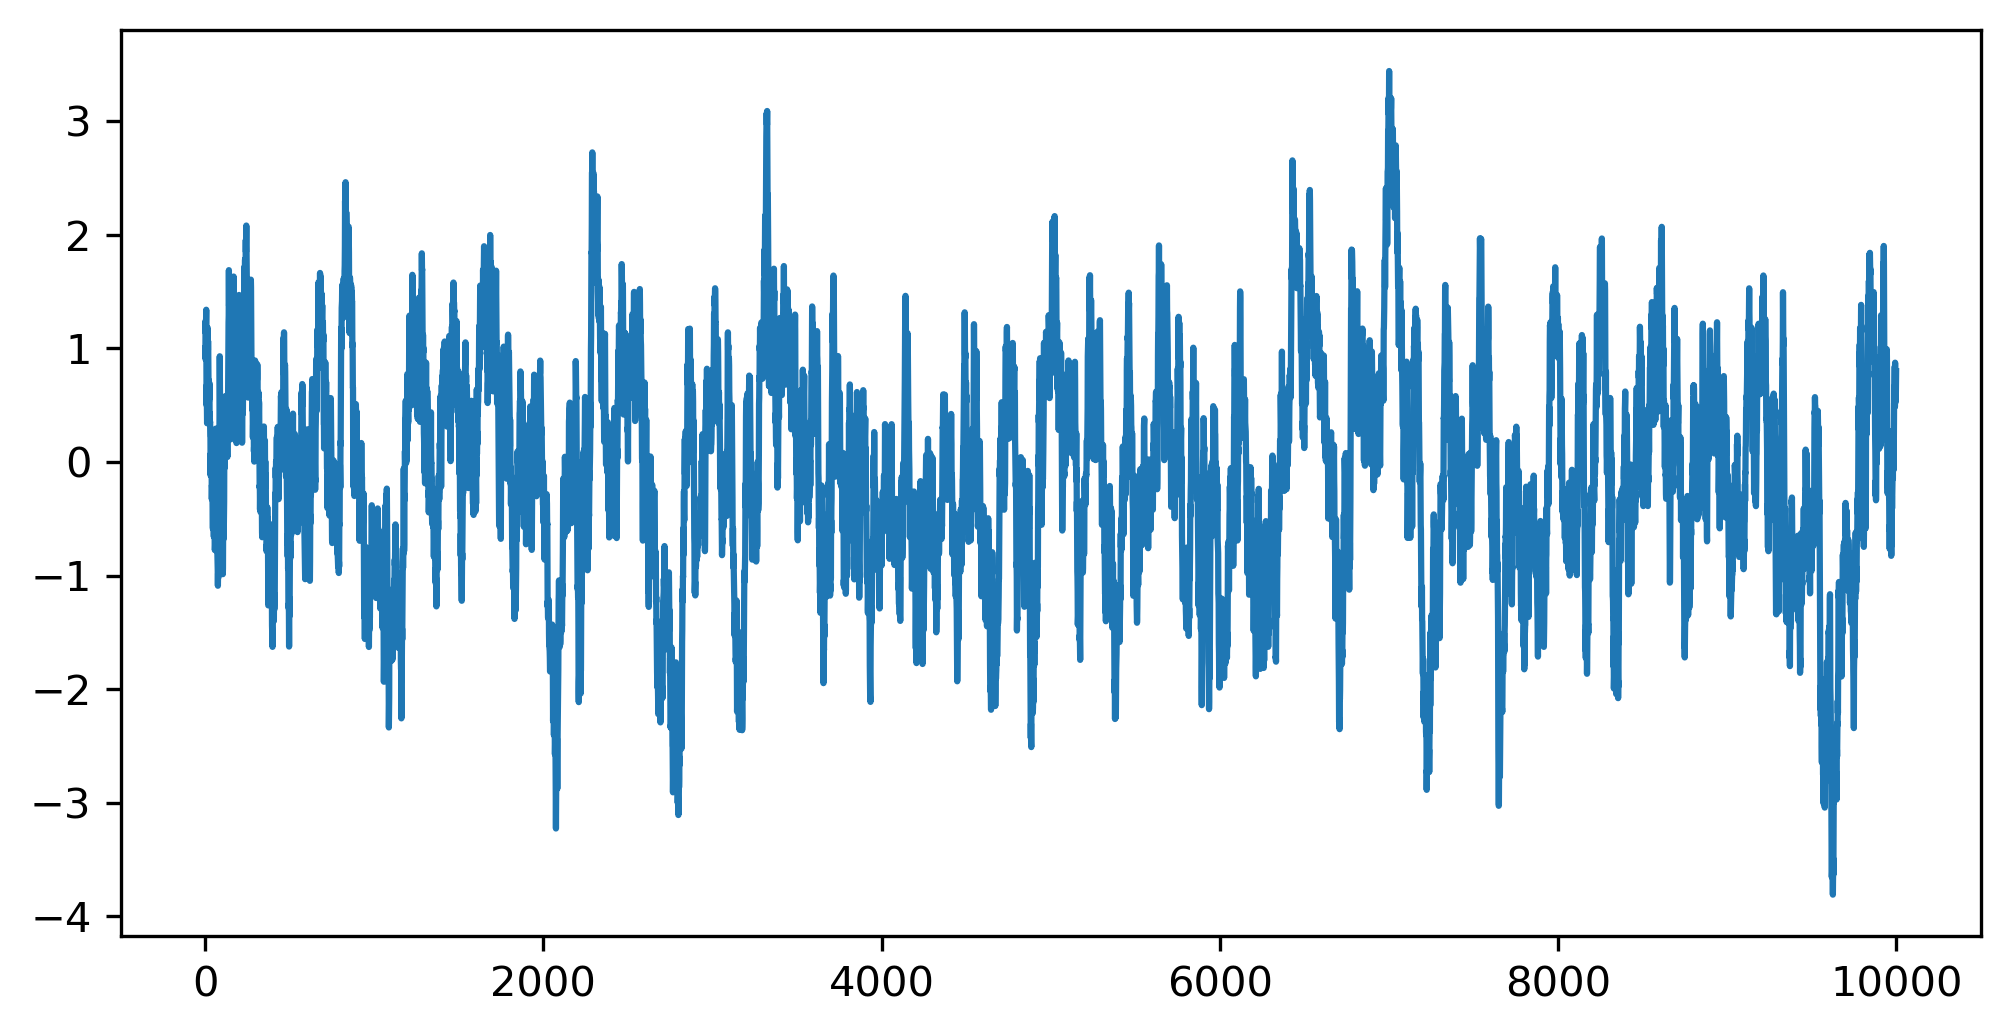

In [9]:
# Generate example correlated timeseries data
ts = correlated_timeseries_example(N=10000, tau=50, seed=415389)
fig, ax = plt.subplots(figsize=(8,4), dpi=300)
ax.plot(ts)

We'll first compute the autocorrelation function of the data

$C_j = C(x_k, x_{k+j}) = \frac{(x_k - \bar{x})(x_{k+j} - \bar{x})}{\sigma_s^2}$

which helps us visualize the correlation length.

The ACF can be computed efficiently using FFT-based spectral methods (implemented as library functions in Numpy).

154 154


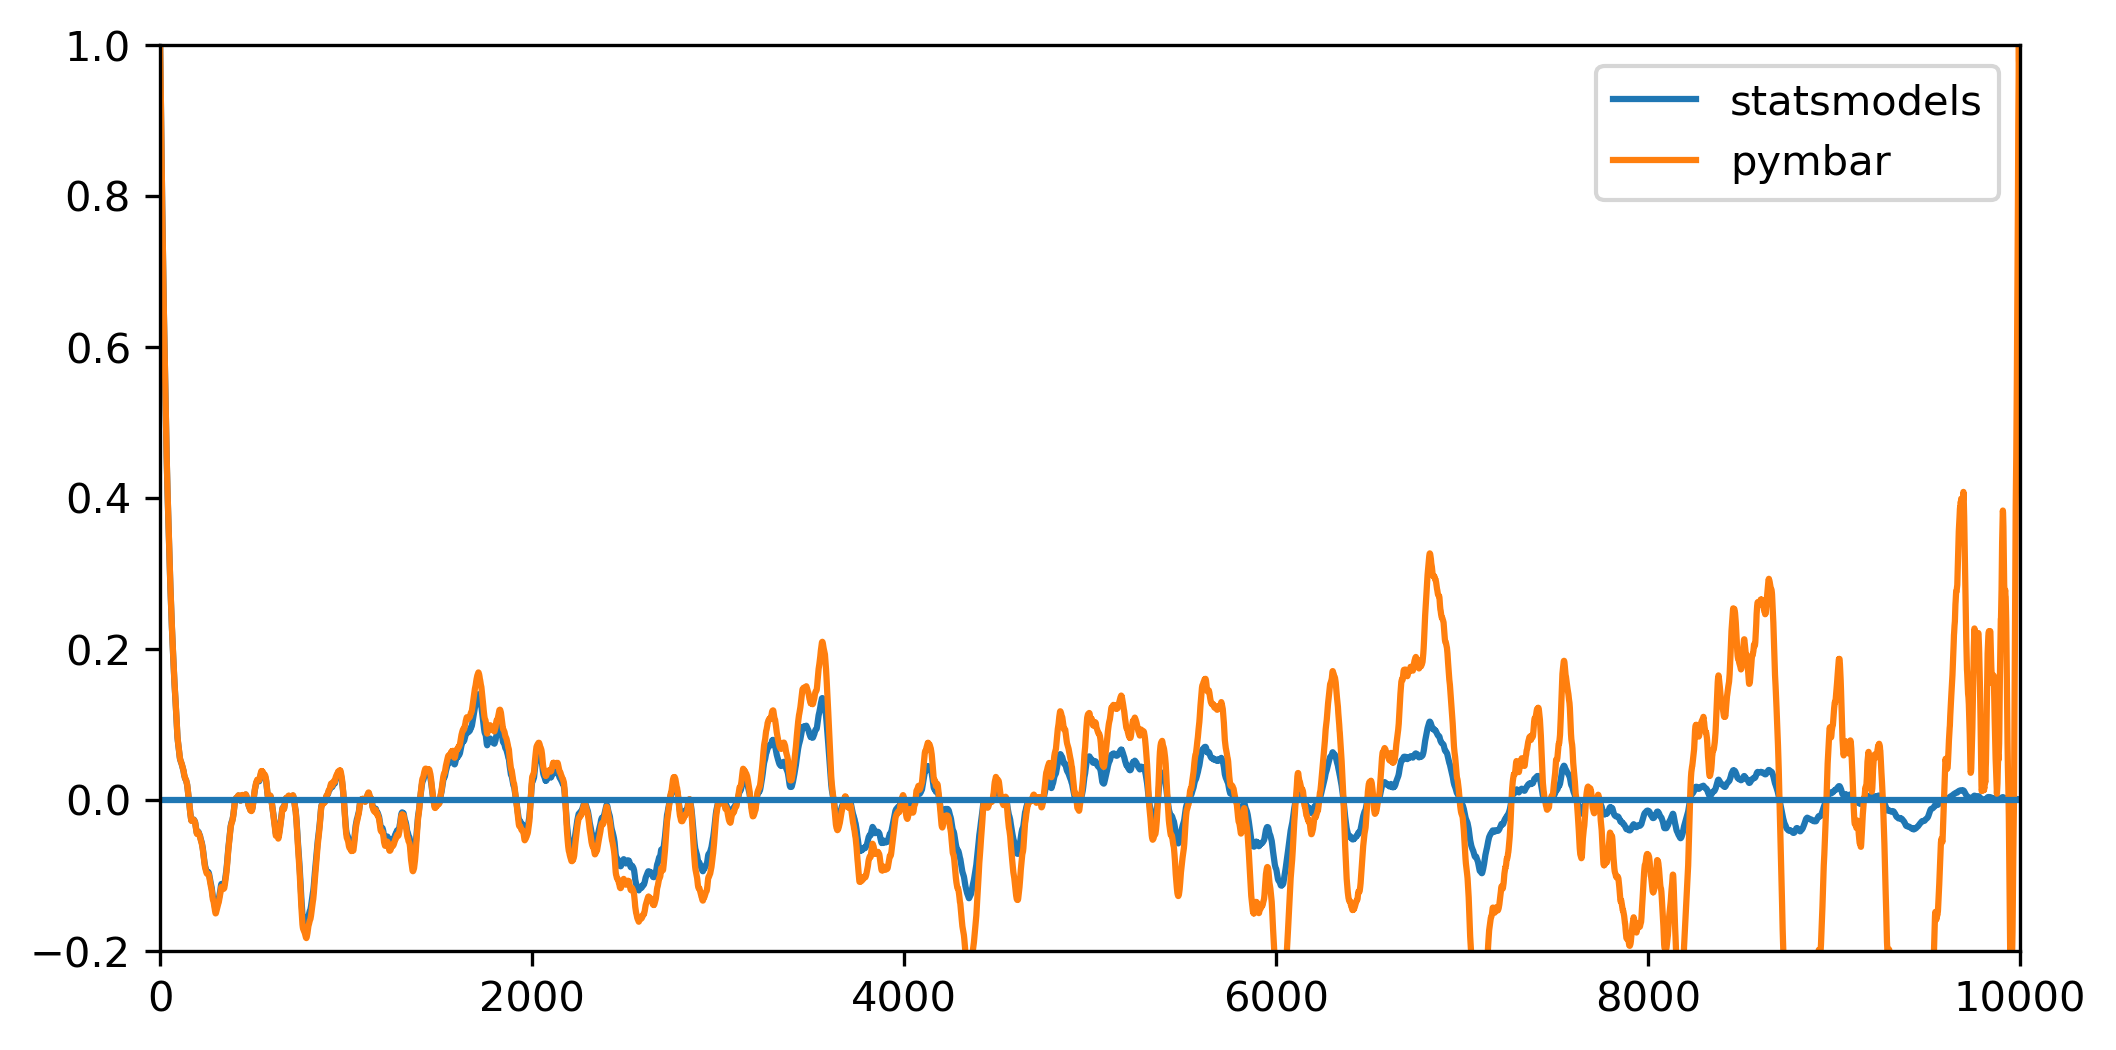

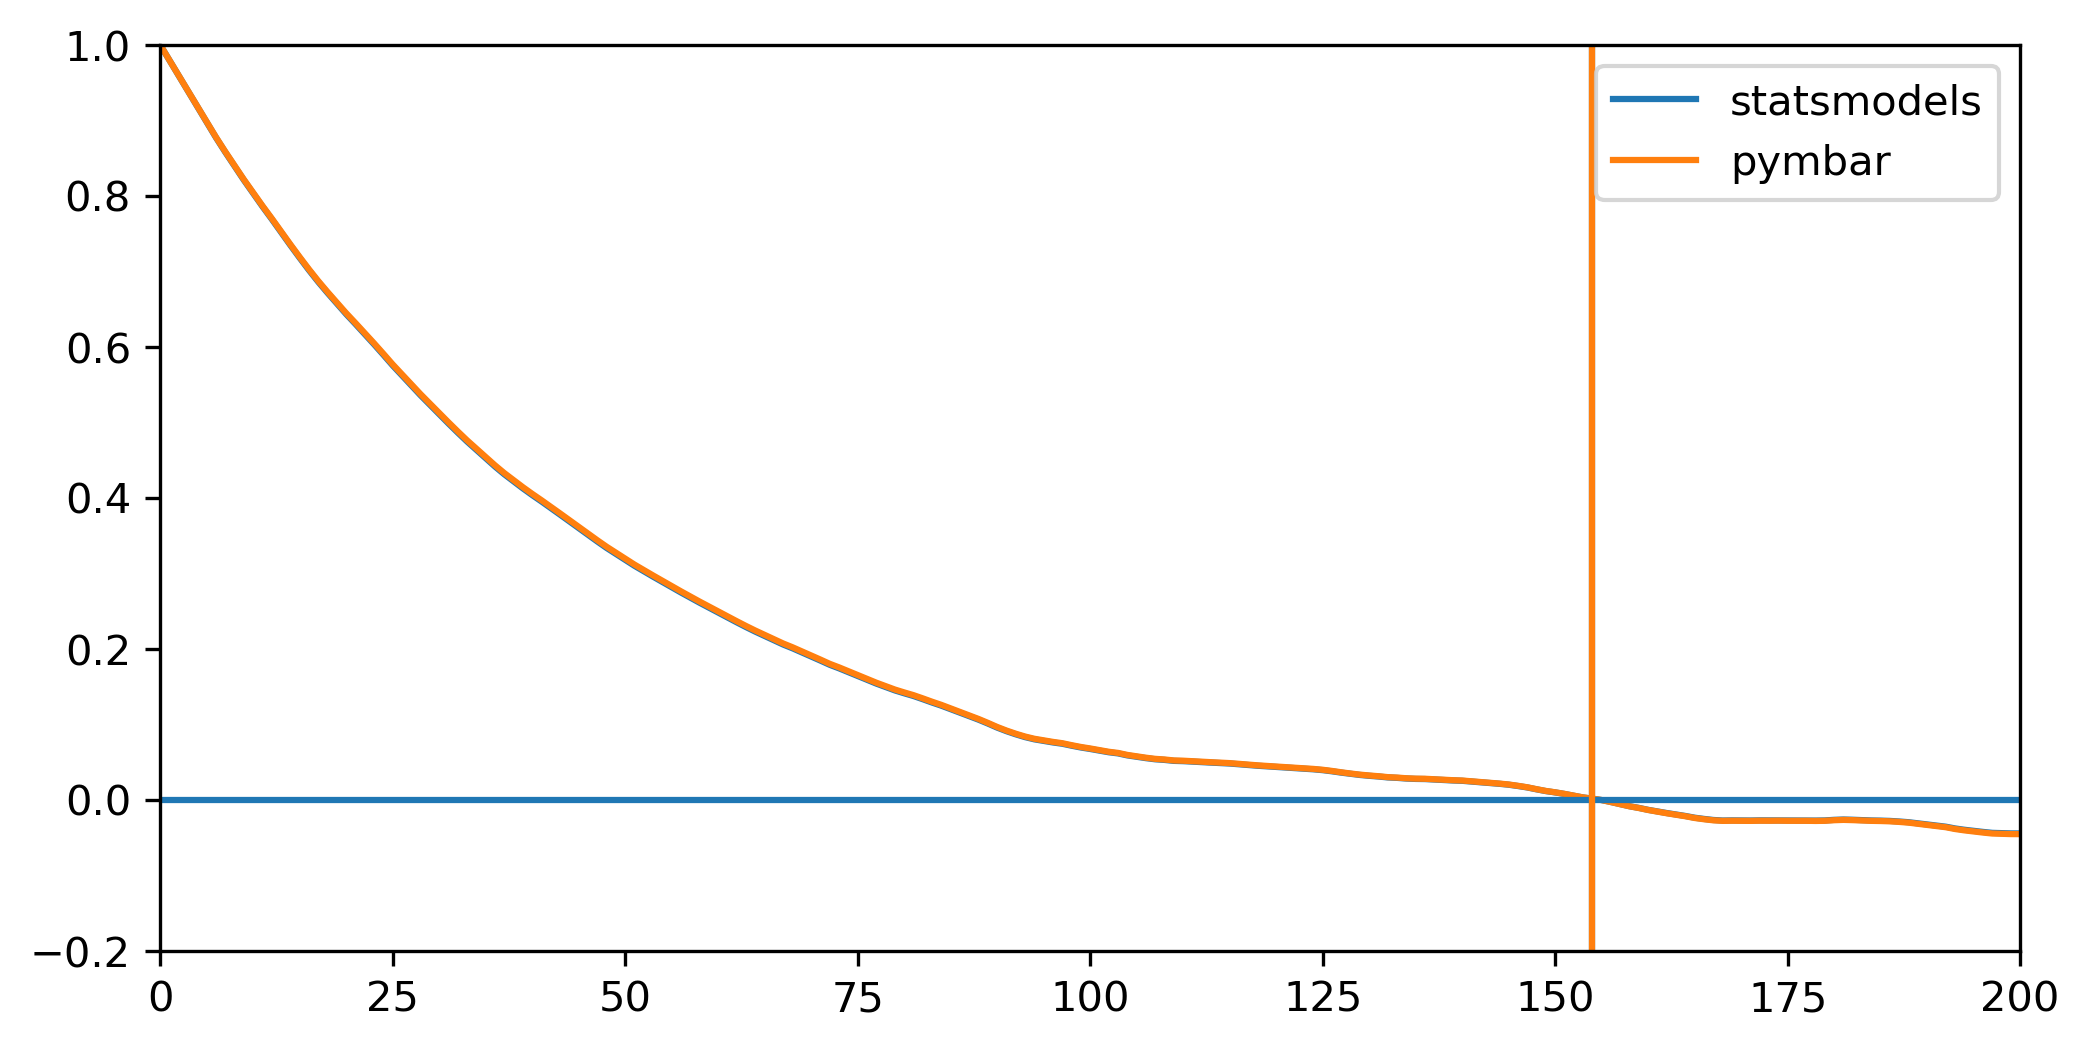

In [10]:
acf = stattools.acf(ts, nlags=10000, fft=True)
# Compare against pymbar
pymbar_acf = pymbar.timeseries.normalizedFluctuationCorrelationFunction(ts)

fig, ax = plt.subplots(figsize=(8,4), dpi=300)
ax.plot(acf, label="statsmodels")
ax.plot(pymbar_acf, label="pymbar")
ax.axhline(y=0)
ax.set_xlim([0, 10000])
ax.set_ylim([-0.2, 1])
ax.legend()

fig, ax = plt.subplots(figsize=(8,4), dpi=300)
ax.plot(acf, label="statsmodels")
ax.plot(pymbar_acf, label="pymbar")
ax.axhline(y=0)
ax.set_xlim([0, 200])
ax.set_ylim([-0.2, 1])
ax.legend()

# Determine point when ACF crosses 0
acf_cross_point = np.argmax(acf < 0) - 1
pymbar_acf_cross_point = np.argmax(pymbar_acf < 0) - 1

print(acf_cross_point, pymbar_acf_cross_point)

ax.axvline(acf_cross_point, color='C0')
ax.axvline(pymbar_acf_cross_point, color='C1')

We can compute the integrated autocorrelation time

$\tau = \sum_{i=1}^{T} (1 - t/T) C_{t}$

and the statistical inefficiency

$g = 1 + 2 \tau$

When computing the integrated autocorrelation time, it is essential to stop accumulating data when the autocorrelation function touches zero. After this point, further accumulation will lead to integrating over noise, which will introduce bias in $\tau$

In [11]:
t = np.array(range(len(ts[:acf_cross_point])))
T = len(ts)
tau = np.sum(np.multiply(np.array(1 - t/T), acf[:acf_cross_point]))
g = 1 + 2 * tau

print(tau, g)

# Compare to pymbar
pymbar_tau = pymbar.timeseries.integratedAutocorrelationTime(ts)
pymbar_g = pymbar.timeseries.statisticalInefficiency(ts, fft=True)

print(pymbar_tau, pymbar_g)

41.006408943904034 83.01281788780807
40.151790880126626 81.30358174327819


Finally, we can use $g$ to estimate the number of independent samples in the data, as

$N_{ind} = N / g$

In [12]:
N_ind = T // g

# Compare to pymbar
N_ind_pymbar = T//pymbar_g

print("Total sample size = {:d}".format(T))
print("Independent sample size = {:.0f} or {:.0f} (pymbar)".format(N_ind, N_ind_pymbar))

Total sample size = 10000
Independent sample size = 120 or 122 (pymbar)


## Standard error of the mean

As the number of independent data points in the sample (~120) is far lower than the total number of data points in the sample (=10000), the naive estimate 

$\sigma_{\bar{x}} = \sigma / \sqrt{N}$

will be far lower than the actual standard error. Therefore, we can't use the naive estimate of standard error when reporting error bars on ensemble average quantities computed from timeseries data. Instead, we must use  statistical techniques to remove autocorrelation bias.

We'll look at four different methods to estimate the standard error of the mean:

- Scaling using statistical inefficiency
- Block averaging
- Bootstrapping
- Block bootstrapping

Ref 1. outlines each of these methods in detail.

### Scaling using statistical inefficiency

$\sigma_{\bar{X}} = \sigma_s / \sqrt{N_{ind}} = \sigma_s / \sqrt{(N/g)}$

In [13]:
sem_naive = ts.std() / np.sqrt(T)
sem_1 = ts.std() / np.sqrt(N_ind)
print("Naive estimate: {:.4f}, scaling estimate: {:.4f}".format(sem_naive, sem_1))

Naive estimate: 0.0099, scaling estimate: 0.0902


### Block averaging

Divide the timeseries data into $M$ non-overlapping blocks of size $n$. Calculate the mean of the elements in each block. Call the mean of the $i^{th}$ block $x_i^b$. Use the $x_i^b$'s to estimate the mean, standard deviation, and standard error of mean.

This works only if the block sizes are large enough so that the blocks are not correlated. 

The block size has to be adjusted to make sure that the blocks are not correlated, or else the uncertainties calculated will be biased.

Read Ref. 1 for more detail

Text(0, 0.5, 'Standard error of the mean')

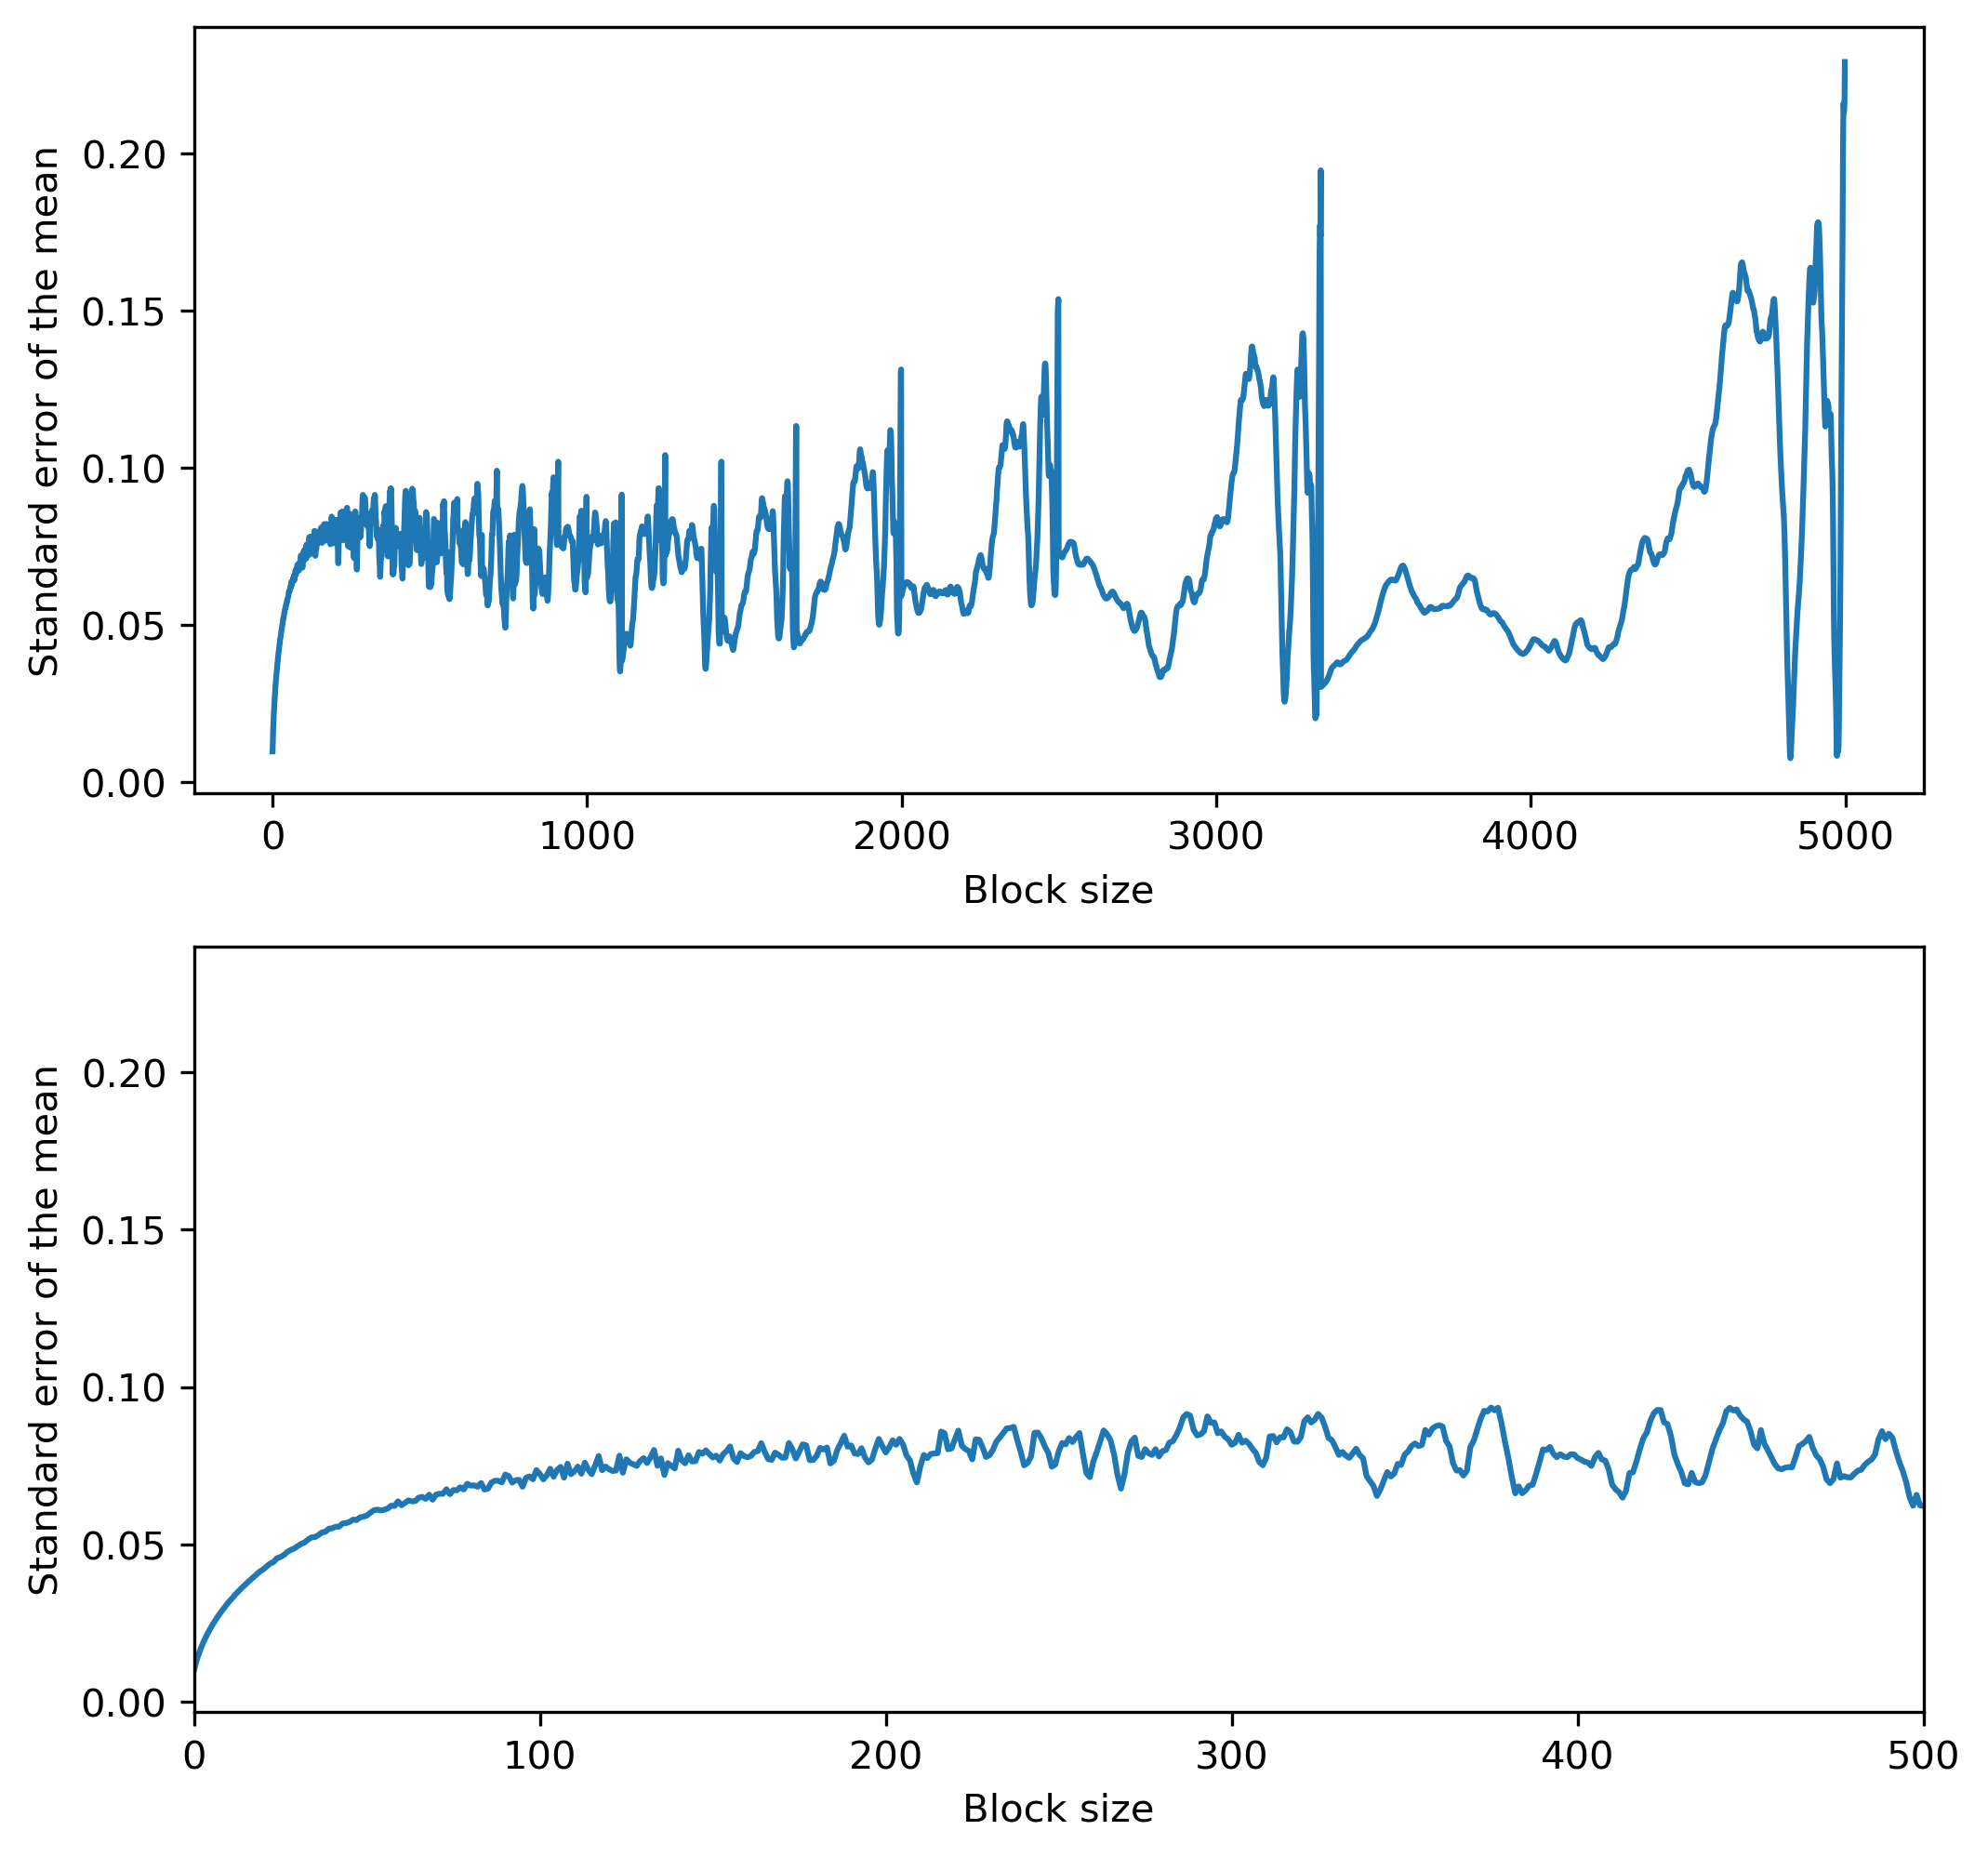

In [14]:
sems_block = []

for block_size in range(1, 5000):
    M = int(np.ceil(len(ts) / block_size))
    blocks = []
    for i in range(M):
        blocks.append(ts[i * block_size : min((i + 1) * block_size, len(ts))].mean())
    blocks = np.array(blocks)
    sem = blocks.std() / np.sqrt(M)
    sems_block.append(sem)

sems_block = np.array(sems_block)

fig, ax = plt.subplots(2, 1, figsize=(8,8), dpi=300)
ax[0].plot(sems_block)
ax[0].set_xlabel("Block size")
ax[0].set_ylabel("Standard error of the mean")

ax[1].plot(sems_block)
ax[1].set_xlim([0, 500])
ax[1].set_xlabel("Block size")
ax[1].set_ylabel("Standard error of the mean")

The block averages appear to converge at a block size of ~300.

In [15]:
block_size = 300
M = int(np.ceil(len(ts) / block_size))
blocks = []
for i in range(M):
    blocks.append(ts[i * block_size : min((i + 1) * block_size, len(ts))].mean())
blocks = np.array(blocks)
sem_2 = blocks.std() / np.sqrt(M)
print("Naive estimate: {:.4f}, Block average sem estimate: {:.4f}".format(sem_naive, sem_2))

Naive estimate: 0.0099, Block average sem estimate: 0.0834


### Bootstrapping

Draw boostrap samples of size $N_{ind} = N / g$.

In [16]:
# Perform bootstrapping
bootsize = int(N_ind) # draw samples of size = number of independent points
nboot = 1000

boot_means = []

for i in range(nboot):
    boot_sample = np.random.choice(ts, size=bootsize)
    boot_means.append(boot_sample.mean())
boot_means = np.array(boot_means)

sem_boot = boot_means.std()
sem_3 = sem_boot
print("Naive estimate: {:.4f}, Bootstrapping sem estimate: {:.4f}".format(sem_naive, sem_3))

Naive estimate: 0.0099, Bootstrapping sem estimate: 0.0907


### Block boostrapping

Perform bootstrapping using non-overlapping blocks (constructed using the procedure outlined above). 

In [17]:
# Construct blocks
block_size = 300 # Obtain from block average correlation analysis
M = int(np.ceil(len(ts) / block_size))
blocks = []
for i in range(M):
    blocks.append(ts[i * block_size : min((i + 1) * block_size, len(ts))].mean())
blocks = np.array(blocks)

# Perform bootstrapping
bootsize = M # draw samples of size = number of independent points
nboot = 1000

block_boot_means = []

for i in range(nboot):
    boot_sample = np.random.choice(blocks, size=bootsize)
    block_boot_means.append(boot_sample.mean())
block_boot_means = np.array(block_boot_means)

sem_block_boot = block_boot_means.std()
sem_4 = sem_block_boot
print("Naive estimate: {:.4f}, Block bootstrapping sem estimate: {:.4f}".format(sem_naive, sem_4))

Naive estimate: 0.0099, Block bootstrapping sem estimate: 0.0823


### Comparing techniques

In [18]:
print(sem_1, sem_2, sem_3, sem_4)

0.0902409204987935 0.08337492078276867 0.090742975 0.08227196
